In [56]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import time
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from datetime import datetime
import plotly.plotly  as py
py.tools.set_credentials_file(username='mcmanusdatascience', api_key='Mkw1SmxGJj1HPglRqBES')
import plotly.graph_objs as go
import plotly.plotly.tools as tls

AttributeError: module 'plotly.plotly' has no attribute 'set_credentials_file'

In [33]:
df = pd.read_csv('2014_bostonmarathonresults.csv')

# Cleaning:

In [34]:
print(df.head())

     10k                name  division    25k gender  age  official bib  \
0  17.37  Yamamoto, Hiroyuki         8  47.67      M   47     85.25  W1   
1  32.58        Jeptoo, Rita         1  82.43      F   33    138.95  F1   
2  16.62   Van Dyk, Ernst F.         1  45.80      M   41     80.60  W2   
3  32.57        Dibaba, Mare         3  82.43      F   24    140.58  F2   
4  17.12      Hokinoue, Kota         2  46.37      M   40     81.23  W3   

   genderdiv  ctz  ... overall  pace  state    30k     5k   half    20k  \
0          8  NaN  ...       8  3.27    NaN  59.18   8.02  39.72  37.65   
1          1  NaN  ...      21  5.30    NaN  99.33  16.22  69.47  65.83   
2          1  NaN  ...       1  3.08    NaN  56.45   7.75  38.03  36.10   
3          3  NaN  ...      27  5.37    NaN  99.33  16.20  69.47  65.83   
4          2  NaN  ...       2  3.10    NaN  57.03   8.02  38.60  36.58   

  country            city     40k  
0     JPN         Fukuoka   80.43  
1     KEN         Eldoret 

In [35]:
df.isnull().sum()

10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64

State seems to be empty for a large number of the individuals in the dataset. I'm going to make two seperate datasets right off the bat - one for Americans and one for foreigners.

In [36]:
df_nationals = df[df['country'] == 'USA' ]
df_nonnationals = df[df['country'] != 'USA']

In [37]:
df_nonnationals.isnull().sum()

10k             0
name            0
division        0
25k             0
gender          0
age             0
official        0
bib             0
genderdiv       0
ctz          4361
35k             0
overall         0
pace            0
state        2576
30k             0
5k              0
half            0
20k             0
country         0
city            1
40k             0
dtype: int64

Great - the data for non-nationals have all the entries without state information. On further inspection, the ctz variable indicates citizenship (for example, not all of the US entries are by US nationals). To be conclusive, let's just go ahead and replace the nan values in state in the original dataset. We'll label them as non-national entry (NNE. While we're at it let's drop that individual who didn't enter their city.

In [39]:
df['state'] = df.state.replace(np.nan, 'NNE', regex=True)

df_nonnationals['state'] = df_nonnationals.state.replace(np.nan, 'NNE', regex=True)
df_nationals['state'] = df_nationals.state.replace(np.nan, 'NNE', regex=True)

df['ctz'] = df.ctz.fillna(df['country'])

df_nonnationals['ctz'] = df_nonnationals.ctz.fillna(df['country'])
df_nationals['ctz'] = df_nationals.ctz.fillna(df['country'])

In [48]:
df = df.dropna(axis=0, how='any')

df_nonnationals=df_nonnationals.dropna(axis=0, how='any')
df_nationals=df_nationals.dropna(axis=0, how='any')

# Data Exploration:

In [49]:
sex_counts_nationals = pd.DataFrame(df_nationals.gender.value_counts())
sex_counts_nonnationals = pd.DataFrame(df_nonnationals.gender.value_counts())

In [105]:
labels = ['Male', 'Female']
values1 = sex_counts_nationals
values2 = sex_counts_nonnationals

trace1 = go.Pie(labels=labels, values=values1, hovertext = 'US entrants', title = 'US entrants by sex' )
trace2 = go.Pie(labels=labels, values=values2, hovertext = 'non-US entrants', title = 'non-US entrants by sex')


py.iplot([trace1], filename='basic_pie_chart')


D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [94]:
py.iplot([trace2], filename='basic_pie_chart')

D:\Anaconda\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Females are significantly more represented in the non-US entrants.

<Figure size 1008x72 with 0 Axes>

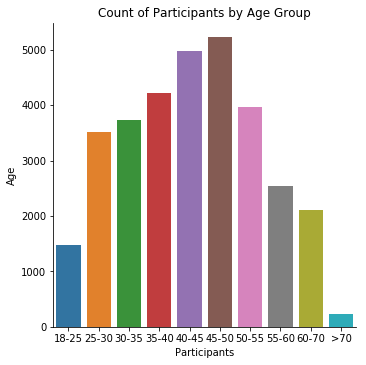

In [156]:
#stolen from Eve
age_bins= [18,25,30,35,40,45,50,55,60,70,(df['age'].max()+1)]

age_labels = ['18-25', '25-30', '30-35', '35-40','40-45', '45-50', '50-55','55-60', '60-70', '>70']
df['age_groups'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

#stolen from Eve 
#Plot the figure
plt.figure(figsize=(14,1))
sns.catplot(x="age_groups", 
            kind="count", 
            data=df)
plt.title('Count of Participants by Age Group')
plt.xlabel('Participants')
plt.ylabel('Age')
plt.show()

Distribution of entrants by age is normally distrubed with a positive skew. A large proportion of the individuals that participate are middle aged (35-55).

<Figure size 1008x72 with 0 Axes>

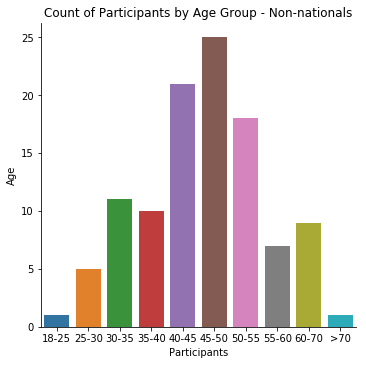

In [157]:
df_nonnationals['age_groups'] = pd.cut(df_nonnationals['age'], bins=age_bins, labels=age_labels, right=False)

#stolen from Eve 
#Plot the figure
plt.figure(figsize=(14,1))
sns.catplot(x="age_groups", 
            kind="count",  
            data=df_nonnationals)
plt.title('Count of Participants by Age Group - Non-nationals')
plt.xlabel('Participants')
plt.ylabel('Age')
plt.show()

<Figure size 1008x72 with 0 Axes>

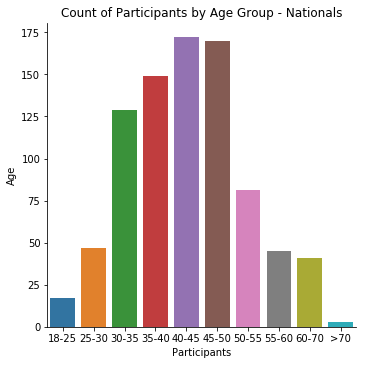

In [158]:
df_nationals['age_groups'] = pd.cut(df_nationals['age'], bins=age_bins, labels=age_labels, right=False)

#stolen from Eve 
#Plot the figure
plt.figure(figsize=(14,1))
sns.catplot(x="age_groups", 
            kind="count", 
            data=df_nationals)
plt.title('Count of Participants by Age Group - Nationals')
plt.xlabel('Participants')
plt.ylabel('Age')
plt.show()

The non-national group is significantly older on average. Probably due to the fact that the 40-50 group probably have more time to travel (and perhaps have the heavy duty on their child rearing behind them).

In [143]:
df_wheelchair = df[df['bib'].str.contains('W')]
df_ablebodied = df[~df['bib'].str.contains('W')]

In [144]:
df_ablebodied.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,pace,state,30k,5k,half,20k,country,city,40k,age_groups
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,KEN,...,5.30,NNE,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,30-35
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,ETH,...,5.37,NNE,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,18-25
5,32.58,"Sumgong, Jemima Jelagat",4,82.45,F,29,140.68,F3,4,KEN,...,5.37,NNE,99.33,16.22,69.47,65.83,KEN,Nandi,132.95,25-30
7,30.48,"Geneti, Markos",5,76.95,M,29,129.83,5,5,ETH,...,4.97,NNE,92.52,15.17,64.85,61.62,ETH,Addis Ababa,122.80,25-30
9,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,USA,...,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83,30-35


# Strategy:

I can't just throw all the features at the clustering alogorithm. If I was to do that, I wouldn't be able to discern any patterns. So first, for this to have any utility, I neeed to select what features i'm going to include. These are the features that I think would be meaningful:

Features for clustering model:
1. Age group: df_ablebodied['age']
2. Sex : df_ablebodied['gender']
3. Position : df_ablebodied['genderdiv']
4. National or non-national entrant: df_ablebodied['natentrant']

Further to all this, I've seperated the data out for those who were in the wheelchair race and those who were not. To keep this simple i'm going to do this analysis on the non-wheelchair racers.

In [147]:
df_ablebodied['natentrant']=df_ablebodied['country'] == 'USA'

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [207]:
X = df_ablebodied[['age','genderdiv','natentrant']]


features = X

#X_norm = normalize(X)

X['genderdiv']=X_norm[:,2]
X['age']=X_norm[:,0]
X['gender']=df_ablebodied['gender']


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Models

I'm going to try this with 2X2X4X4 clusters. These numbers reflect

# K-Means

In [183]:
# K Means

from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=4).fit_predict(X)

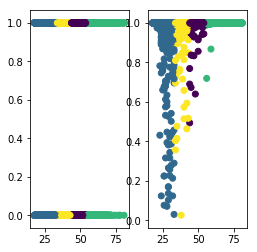

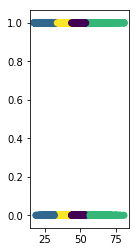

In [199]:
#Plot the solution
fig = plt.figure()

plt.subplot(1,3, 1)
plt.scatter(X['age'],X['gender'], c=y_pred)

plt.subplot(1,3, 2)
plt.scatter(X['age'],X['genderdiv'], c=y_pred)
plt.show()
plt.subplot(1,3, 3)
plt.scatter(X['age'],X['natentrant'], c=y_pred)
plt.show()

What this shows is that the groups are primarily formed on the basis of rank in the race and age. Sex and national entrant status have lesser effects. If we look at these grouping in higher resolution/zoom we can begin to tease their effects out.

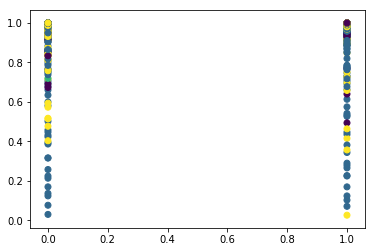

In [202]:
plt.scatter(X['gender'],X['genderdiv'], c=y_pred)
plt.show()

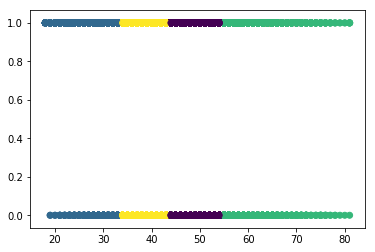

Ok, i'm going back to the start here and i'm making this simpler. It is possible to use binary variables in clustering, but not the way i'm currently doing it. I'm only looking at AGE and Position and i'm going to seperate the datasets by sex.

# Back to the drawing board.

In [209]:
X_male = X[X['gender'] == 'M' ]
X_female = X[X['gender'] == 'F' ]

X_male = X_male.drop('gender', 1)
X_female = X_female.drop('gender', 1)

X_male = X_male.drop('natentrant', 1)
X_female = X_female.drop('natentrant', 1)

Ok, now we're going to look at how the interaction of age and placement influences grouping for groups of males and groups of females. I think it would be meaningful to include a total of 7 groups for the following reasons:

Functionally, runners are in their peak between 25-35. There are a large number of runners in middle age, and then there are a smaller group of runners in the post 50 group. This gives us a total of 3 groupings by age. I think it would make sense to group runners by placement by the quartiles. As there will be a natural overlap of these features, I'm going to start with the sum of these groups.

# K-Means - 2nd try

In [215]:
# K Means

from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=4).fit_predict(X_male)

In [ ]:
print(df)

In [ ]:
plt.scatter(X_male['age'],X_male['genderdiv'], c=y_pred)
plt.xlabel("Normalized Placement")
plt.ylabel("Normalized Age")
plt.show()

In [ ]:
This is what we would expect. there are a clear groupings here that are dependent on the interaction between age and results. 
This should hold for female participants also.

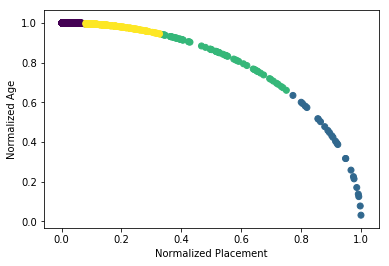

In [228]:
y_pred = KMeans(n_clusters=4).fit_predict(X_female)
plt.scatter(X_female['age'],X_female['genderdiv'], c=y_pred)
plt.xlabel("Normalized Placement")
plt.ylabel("Normalized Age")
plt.show()

In [ ]:
The data looks almost identical.

# Means Shift

Number of estimated clusters: 55


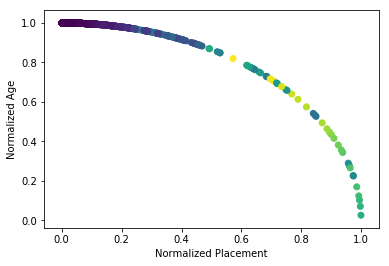

In [229]:
# Mean Shift

from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_male, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_male)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_male['age'], X_male['genderdiv'], c=labels)
plt.xlabel("Normalized Placement")
plt.ylabel("Normalized Age")
plt.show()

There's a little more overlap in the groups by using K-means. I imagine this is also the case with the female group. 

It also seems like there is a some over estimation of cluster sizes going on here (at least for the utility of this analysis)

Number of estimated clusters: 46


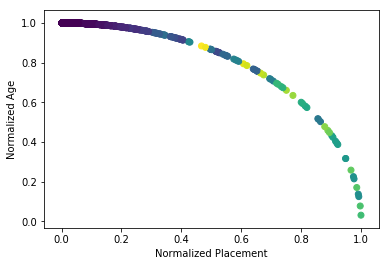

In [230]:
# Mean Shift

from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_female, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_female)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_female['age'], X_female['genderdiv'], c=labels)
plt.xlabel("Normalized Placement")
plt.ylabel("Normalized Age")
plt.show()

In [ ]:
Similar result.

# Heirarchial

In [221]:
# Heirarchical 

from sklearn.cluster import AgglomerativeClustering

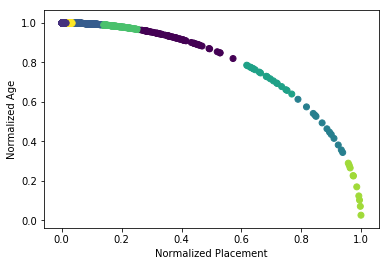

In [239]:
heir = AgglomerativeClustering(n_clusters=8, 
                        affinity='euclidean', 
                        memory=None, 
                        connectivity=None, 
                        compute_full_tree='auto', 
                        linkage='ward', 
                        pooling_func='deprecated')

heir.fit(X_male)

y_pred = heir.fit_predict(X_male)

plt.scatter(X_male['age'], X_male['genderdiv'], c=y_pred)
plt.xlabel("Normalized Placement")
plt.ylabel("Normalized Age")
plt.show()

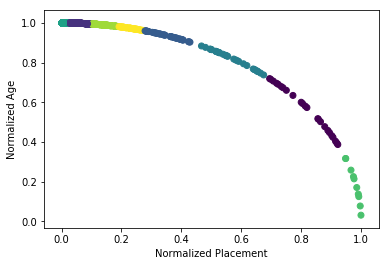

In [233]:
heir = AgglomerativeClustering(n_clusters=8, 
                        affinity='euclidean', 
                        memory=None, 
                        connectivity=None, 
                        compute_full_tree='auto', 
                        linkage='ward', 
                        pooling_func='deprecated')

heir.fit(X_female)

y_pred = heir.fit_predict(X_female)

plt.scatter(X_female['age'], X_female['genderdiv'], c=y_pred)
plt.xlabel("Normalized Placement")
plt.ylabel("Normalized Age")
plt.show()

# Report

Of these models Heirarchial clustering and and K-means do the best job. The Mean Shift clustering algorithm produce a few too many clusters to be of utility in this context. 

Essentially what we can see here, is that there is a relationship between age and finishing place in the race. Based on these relationships we can make distinct groups based on how individuals perform in the race. If we graph this a in regular context it will look like this:

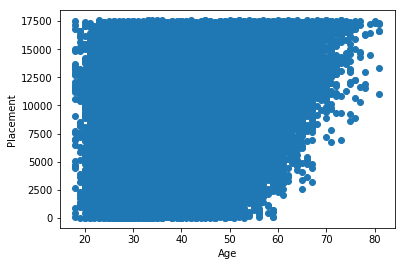

In [238]:
plt.scatter(df['age'], df['genderdiv'])
plt.xlabel("Age")
plt.ylabel("Placement")
plt.show()

If we superimpose the groups on top of this plot it will look like this:

In [237]:
df_ablebodied_maleplot = df_ablebodied[df_ablebodied['gender'] == 'M' ]

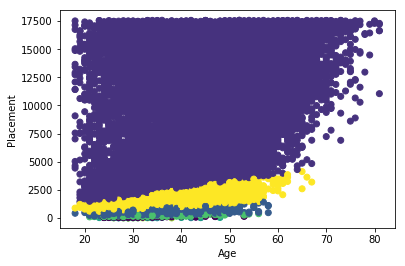

In [240]:
plt.scatter(df_ablebodied_maleplot['age'], df_ablebodied_maleplot['genderdiv'], c=y_pred)
plt.xlabel("Age")
plt.ylabel("Placement")
plt.show()

Essentially these groups give generate a topological heirarchy of runners adjusted for age. For example. There are a few runners age between 60-70 in yellow, this yellow group perform better, when adjusted by their age than the purple group.